# Read dataset and create data loaders

In [1]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [2]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Reference for augmentation: https://pytorch.org/vision/stable/transforms.html
'''
batch_size=64 
print('Batch size:', batch_size)

# Normalisation and std values for RGB in dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),        # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Randomly translate the image
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=mean, std=std),  # Normalize with mean and std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # Randomly erase a portion of the image (optional)
])

# No augmentation for test set (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize with mean and std
])

# Load training and testing datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Batch size: 64
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [4]:
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self, input_channels, middle_channels, output_channels):
     super(Stem,self).__init__()
     # Default parameters
     kernel_size=3
     stride=1
     padding=1
     
     # Combine multiple layers
     self.stem = nn.Sequential(
       nn.Conv2d(input_channels, middle_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels), 
       nn.ReLU(inplace=True),
       nn.Conv2d(middle_channels, middle_channels,kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(middle_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(output_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    return x

## Expert Branch

In [5]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k, r):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

## Block

In [6]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k, r):
    super(Block, self).__init__()

    # Default parameters
    kernel_size=3
    stride=1
    padding=1

    # Set parameters
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)

    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

    # If dimensions do not match
    self.downsample = None
    if input_channels != output_channels:
        self.downsample = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

  def forward(self,x):
    identity= x
    # Vector a from expert branch
    a = self.expertBranch(x)
    # Convolutional layers 
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)

    # Create vector O
    a= a.view(a.size(0), self.k, 1,1,1)
    out = (a* stacked).sum(dim=1)

    # Apply downsampling for mismatched dimensions
    if self.downsample is not None:
        identity = self.downsample(identity)
        
    # Skip connection to stablise gradient descent
    out += identity
    out = F.relu(out) # activation after skip

    return out

## Backbone

In [7]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels, hidden_channels, num_blocks, k, r):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      x = block(x)
    return x

## Classifier

In [8]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes, use_mlp):
    super(Classifier,self).__init__()
    # Default parameters
    dropout_rate=0.4
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(dropout_rate), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    out = self.classifier(x)
    return out


# Model

In [9]:
class Model(nn.Module):
  def __init__(self, input_channels, output_channels, middle_channels, hidden_channels, num_blocks, k, r, num_classes, use_mlp):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem(
      input_channels=input_channels,
      middle_channels=middle_channels,
      output_channels=output_channels
    )
    # Call backbone
    self.backbone= Backbone(
      input_channels=output_channels, 
      hidden_channels= hidden_channels, 
      num_blocks=num_blocks,
      k=k, 
      r=r)
    # Call classifier
    self.classifier= Classifier(
      input_channels=hidden_channels, 
      num_classes=num_classes,
      use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [10]:
model = Model(
    input_channels=3,
    output_channels=128,
    middle_channels=64,
    hidden_channels=256,
    num_blocks=8,
    k=6,
    r=4,
    num_classes=10,
    use_mlp=True
)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-4, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=195)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[5]
)

# Training & Testing


Epoch 1/200


Train Loss: 2.2791 | Accuracy: 16.23%
Val   Loss: 2.0399 | Accuracy: 25.71%
Saved best model.

Epoch 2/200


Train Loss: 2.0803 | Accuracy: 23.71%
Val   Loss: 1.9371 | Accuracy: 32.49%
Saved best model.

Epoch 3/200


Train Loss: 2.0042 | Accuracy: 28.28%
Val   Loss: 1.7775 | Accuracy: 39.89%
Saved best model.

Epoch 4/200


Train Loss: 1.9457 | Accuracy: 31.55%
Val   Loss: 1.7567 | Accuracy: 39.79%
No improvement for 1 epochs.

Epoch 5/200


Train Loss: 1.8829 | Accuracy: 35.13%
Val   Loss: 1.6986 | Accuracy: 44.45%
Saved best model.

Epoch 6/200


Train Loss: 1.8295 | Accuracy: 38.24%
Val   Loss: 1.5568 | Accuracy: 49.95%
Saved best model.

Epoch 7/200


Train Loss: 1.7780 | Accuracy: 41.20%
Val   Loss: 1.5194 | Accuracy: 52.53%
Saved best model.

Epoch 8/200


Train Loss: 1.7381 | Accuracy: 42.99%
Val   Loss: 1.3917 | Accuracy: 59.64%
Saved best model.

Epoch 9/200


Train Loss: 1.7049 | Accuracy: 44.72%
Val   Loss: 1.3979 | Accuracy: 58.34%
No improvement for 1 epochs.

Epoch 10/200


Train Loss: 1.6775 | Accuracy: 46.18%
Val   Loss: 1.4056 | Accuracy: 57.96%
No improvement for 2 epochs.

Epoch 11/200


Train Loss: 1.6416 | Accuracy: 47.95%
Val   Loss: 1.3479 | Accuracy: 61.34%
Saved best model.

Epoch 12/200


Train Loss: 1.6214 | Accuracy: 49.20%
Val   Loss: 1.3243 | Accuracy: 61.82%
Saved best model.

Epoch 13/200


Train Loss: 1.5942 | Accuracy: 50.47%
Val   Loss: 1.2426 | Accuracy: 66.13%
Saved best model.

Epoch 14/200


Train Loss: 1.5733 | Accuracy: 51.59%
Val   Loss: 1.2002 | Accuracy: 68.79%
Saved best model.

Epoch 15/200


Train Loss: 1.5492 | Accuracy: 52.59%
Val   Loss: 1.2024 | Accuracy: 68.50%
No improvement for 1 epochs.

Epoch 16/200


Train Loss: 1.5235 | Accuracy: 53.84%
Val   Loss: 1.2688 | Accuracy: 65.68%
No improvement for 2 epochs.

Epoch 17/200


Train Loss: 1.5042 | Accuracy: 54.75%
Val   Loss: 1.1653 | Accuracy: 70.06%
Saved best model.

Epoch 18/200


Train Loss: 1.4858 | Accuracy: 55.75%
Val   Loss: 1.1753 | Accuracy: 70.23%
Saved best model.

Epoch 19/200


Train Loss: 1.4694 | Accuracy: 56.72%
Val   Loss: 1.1327 | Accuracy: 71.89%
Saved best model.

Epoch 20/200


Train Loss: 1.4513 | Accuracy: 57.68%
Val   Loss: 1.1392 | Accuracy: 71.32%
No improvement for 1 epochs.

Epoch 21/200


Train Loss: 1.4396 | Accuracy: 58.23%
Val   Loss: 1.0745 | Accuracy: 74.63%
Saved best model.

Epoch 22/200


Train Loss: 1.4248 | Accuracy: 58.80%
Val   Loss: 1.0371 | Accuracy: 76.84%
Saved best model.

Epoch 23/200


Train Loss: 1.4092 | Accuracy: 59.81%
Val   Loss: 1.0462 | Accuracy: 76.22%
No improvement for 1 epochs.

Epoch 24/200


Train Loss: 1.3969 | Accuracy: 60.31%
Val   Loss: 1.0456 | Accuracy: 76.00%
No improvement for 2 epochs.

Epoch 25/200


Train Loss: 1.3875 | Accuracy: 60.72%
Val   Loss: 0.9971 | Accuracy: 78.34%
Saved best model.

Epoch 26/200


Train Loss: 1.3676 | Accuracy: 61.68%
Val   Loss: 1.0171 | Accuracy: 77.45%
No improvement for 1 epochs.

Epoch 27/200


Train Loss: 1.3559 | Accuracy: 62.19%
Val   Loss: 1.0327 | Accuracy: 76.98%
No improvement for 2 epochs.

Epoch 28/200


Train Loss: 1.3489 | Accuracy: 62.55%
Val   Loss: 0.9669 | Accuracy: 80.08%
Saved best model.

Epoch 29/200


Train Loss: 1.3349 | Accuracy: 63.14%
Val   Loss: 0.9921 | Accuracy: 78.45%
No improvement for 1 epochs.

Epoch 30/200


Train Loss: 1.3298 | Accuracy: 63.55%
Val   Loss: 0.9568 | Accuracy: 79.97%
No improvement for 2 epochs.

Epoch 31/200


Train Loss: 1.3210 | Accuracy: 63.80%
Val   Loss: 1.0135 | Accuracy: 77.59%
No improvement for 3 epochs.

Epoch 32/200


Train Loss: 1.3100 | Accuracy: 64.49%
Val   Loss: 0.9504 | Accuracy: 80.45%
Saved best model.

Epoch 33/200


Train Loss: 1.3045 | Accuracy: 64.60%
Val   Loss: 0.9328 | Accuracy: 81.38%
Saved best model.

Epoch 34/200


Train Loss: 1.2996 | Accuracy: 64.75%
Val   Loss: 0.9280 | Accuracy: 81.19%
No improvement for 1 epochs.

Epoch 35/200


Train Loss: 1.2921 | Accuracy: 65.11%
Val   Loss: 0.9210 | Accuracy: 81.51%
Saved best model.

Epoch 36/200


Train Loss: 1.2808 | Accuracy: 66.05%
Val   Loss: 1.0069 | Accuracy: 78.01%
No improvement for 1 epochs.

Epoch 37/200


Train Loss: 1.2786 | Accuracy: 65.80%
Val   Loss: 1.0002 | Accuracy: 78.61%
No improvement for 2 epochs.

Epoch 38/200


Train Loss: 1.2729 | Accuracy: 66.10%
Val   Loss: 0.9209 | Accuracy: 81.54%
Saved best model.

Epoch 39/200


Train Loss: 1.2668 | Accuracy: 66.37%
Val   Loss: 0.9095 | Accuracy: 82.39%
Saved best model.

Epoch 40/200


Train Loss: 1.2583 | Accuracy: 66.61%
Val   Loss: 0.9029 | Accuracy: 82.87%
Saved best model.

Epoch 41/200


Train Loss: 1.2507 | Accuracy: 67.04%
Val   Loss: 0.9099 | Accuracy: 82.12%
No improvement for 1 epochs.

Epoch 42/200


Train Loss: 1.2448 | Accuracy: 67.34%
Val   Loss: 0.8893 | Accuracy: 83.39%
Saved best model.

Epoch 43/200


Train Loss: 1.2400 | Accuracy: 67.54%
Val   Loss: 0.9295 | Accuracy: 81.51%
No improvement for 1 epochs.

Epoch 44/200


Train Loss: 1.2361 | Accuracy: 67.84%
Val   Loss: 0.8869 | Accuracy: 83.17%
No improvement for 2 epochs.

Epoch 45/200


Train Loss: 1.2303 | Accuracy: 67.99%
Val   Loss: 0.8945 | Accuracy: 82.89%
No improvement for 3 epochs.

Epoch 46/200


Train Loss: 1.2217 | Accuracy: 68.45%
Val   Loss: 0.8651 | Accuracy: 84.46%
Saved best model.

Epoch 47/200


Train Loss: 1.2216 | Accuracy: 68.31%
Val   Loss: 0.8663 | Accuracy: 84.10%
No improvement for 1 epochs.

Epoch 48/200


Train Loss: 1.2155 | Accuracy: 68.92%
Val   Loss: 0.8476 | Accuracy: 84.99%
Saved best model.

Epoch 49/200


Train Loss: 1.2103 | Accuracy: 68.84%
Val   Loss: 0.8743 | Accuracy: 83.90%
No improvement for 1 epochs.

Epoch 50/200


Train Loss: 1.2016 | Accuracy: 69.29%
Val   Loss: 0.8603 | Accuracy: 84.28%
No improvement for 2 epochs.

Epoch 51/200


Train Loss: 1.2047 | Accuracy: 69.26%
Val   Loss: 0.8471 | Accuracy: 85.14%
Saved best model.

Epoch 52/200


Train Loss: 1.2048 | Accuracy: 69.13%
Val   Loss: 0.8558 | Accuracy: 84.85%
No improvement for 1 epochs.

Epoch 53/200


Train Loss: 1.1979 | Accuracy: 69.55%
Val   Loss: 0.8420 | Accuracy: 85.28%
Saved best model.

Epoch 54/200


Train Loss: 1.1956 | Accuracy: 69.52%
Val   Loss: 0.8524 | Accuracy: 85.03%
No improvement for 1 epochs.

Epoch 55/200


Train Loss: 1.1909 | Accuracy: 69.79%
Val   Loss: 0.8517 | Accuracy: 84.71%
No improvement for 2 epochs.

Epoch 56/200


Train Loss: 1.1836 | Accuracy: 70.24%
Val   Loss: 0.8236 | Accuracy: 86.23%
Saved best model.

Epoch 57/200


Train Loss: 1.1822 | Accuracy: 70.07%
Val   Loss: 0.8424 | Accuracy: 84.84%
No improvement for 1 epochs.

Epoch 58/200


Train Loss: 1.1782 | Accuracy: 70.26%
Val   Loss: 0.8503 | Accuracy: 84.89%
No improvement for 2 epochs.

Epoch 59/200


Train Loss: 1.1777 | Accuracy: 70.32%
Val   Loss: 0.8232 | Accuracy: 86.03%
No improvement for 3 epochs.

Epoch 60/200


Train Loss: 1.1756 | Accuracy: 70.44%
Val   Loss: 0.8484 | Accuracy: 85.03%
No improvement for 4 epochs.

Epoch 61/200


Train Loss: 1.1721 | Accuracy: 70.65%
Val   Loss: 0.8251 | Accuracy: 85.97%
No improvement for 5 epochs.

Epoch 62/200


Train Loss: 1.1641 | Accuracy: 71.11%
Val   Loss: 0.8372 | Accuracy: 85.34%
No improvement for 6 epochs.

Epoch 63/200


Train Loss: 1.1634 | Accuracy: 70.97%
Val   Loss: 0.8153 | Accuracy: 86.18%
No improvement for 7 epochs.

Epoch 64/200


Train Loss: 1.1657 | Accuracy: 70.86%
Val   Loss: 0.8292 | Accuracy: 85.60%
No improvement for 8 epochs.

Epoch 65/200


Train Loss: 1.1605 | Accuracy: 71.19%
Val   Loss: 0.8329 | Accuracy: 85.57%
No improvement for 9 epochs.

Epoch 66/200


Train Loss: 1.1581 | Accuracy: 71.23%
Val   Loss: 0.8251 | Accuracy: 85.79%
No improvement for 10 epochs.

Epoch 67/200


Train Loss: 1.1484 | Accuracy: 71.57%
Val   Loss: 0.8733 | Accuracy: 84.16%
No improvement for 11 epochs.

Epoch 68/200


Train Loss: 1.1503 | Accuracy: 71.67%
Val   Loss: 0.8031 | Accuracy: 86.75%
Saved best model.

Epoch 69/200


Train Loss: 1.1393 | Accuracy: 72.08%
Val   Loss: 0.8149 | Accuracy: 86.52%
No improvement for 1 epochs.

Epoch 70/200


Train Loss: 1.1442 | Accuracy: 71.93%
Val   Loss: 0.8049 | Accuracy: 86.79%
Saved best model.

Epoch 71/200


Train Loss: 1.1451 | Accuracy: 71.61%
Val   Loss: 0.8079 | Accuracy: 86.63%
No improvement for 1 epochs.

Epoch 72/200


Train Loss: 1.1389 | Accuracy: 72.02%
Val   Loss: 0.8076 | Accuracy: 86.34%
No improvement for 2 epochs.

Epoch 73/200


Train Loss: 1.1359 | Accuracy: 72.46%
Val   Loss: 0.8013 | Accuracy: 86.64%
No improvement for 3 epochs.

Epoch 74/200


Train Loss: 1.1336 | Accuracy: 72.29%
Val   Loss: 0.8253 | Accuracy: 85.49%
No improvement for 4 epochs.

Epoch 75/200


Train Loss: 1.1336 | Accuracy: 72.29%
Val   Loss: 0.8042 | Accuracy: 86.84%
Saved best model.

Epoch 76/200


Train Loss: 1.1294 | Accuracy: 72.55%
Val   Loss: 0.8053 | Accuracy: 86.74%
No improvement for 1 epochs.

Epoch 77/200


Train Loss: 1.1221 | Accuracy: 73.06%
Val   Loss: 0.8171 | Accuracy: 86.05%
No improvement for 2 epochs.

Epoch 78/200


Train Loss: 1.1258 | Accuracy: 72.62%
Val   Loss: 0.7793 | Accuracy: 87.96%
Saved best model.

Epoch 79/200


Train Loss: 1.1198 | Accuracy: 73.06%
Val   Loss: 0.7764 | Accuracy: 88.05%
Saved best model.

Epoch 80/200


Train Loss: 1.1182 | Accuracy: 73.01%
Val   Loss: 0.7951 | Accuracy: 87.09%
No improvement for 1 epochs.

Epoch 81/200


Train Loss: 1.1160 | Accuracy: 72.98%
Val   Loss: 0.8018 | Accuracy: 86.98%
No improvement for 2 epochs.

Epoch 82/200


Train Loss: 1.1129 | Accuracy: 73.23%
Val   Loss: 0.7731 | Accuracy: 88.26%
Saved best model.

Epoch 83/200


Train Loss: 1.1118 | Accuracy: 73.31%
Val   Loss: 0.7966 | Accuracy: 87.02%
No improvement for 1 epochs.

Epoch 84/200


Train Loss: 1.1067 | Accuracy: 73.66%
Val   Loss: 0.7924 | Accuracy: 86.93%
No improvement for 2 epochs.

Epoch 85/200


Train Loss: 1.1102 | Accuracy: 73.42%
Val   Loss: 0.8060 | Accuracy: 86.95%
No improvement for 3 epochs.

Epoch 86/200


Train Loss: 1.1070 | Accuracy: 73.56%
Val   Loss: 0.7797 | Accuracy: 87.88%
No improvement for 4 epochs.

Epoch 87/200


Train Loss: 1.1044 | Accuracy: 73.65%
Val   Loss: 0.7866 | Accuracy: 87.61%
No improvement for 5 epochs.

Epoch 88/200


Train Loss: 1.1065 | Accuracy: 73.55%
Val   Loss: 0.7704 | Accuracy: 88.31%
Saved best model.

Epoch 89/200


Train Loss: 1.1011 | Accuracy: 73.78%
Val   Loss: 0.7724 | Accuracy: 88.24%
No improvement for 1 epochs.

Epoch 90/200


Train Loss: 1.0973 | Accuracy: 73.93%
Val   Loss: 0.7782 | Accuracy: 88.02%
No improvement for 2 epochs.

Epoch 91/200


Train Loss: 1.1007 | Accuracy: 73.64%
Val   Loss: 0.7823 | Accuracy: 87.51%
No improvement for 3 epochs.

Epoch 92/200


Train Loss: 1.0989 | Accuracy: 73.80%
Val   Loss: 0.7762 | Accuracy: 87.90%
No improvement for 4 epochs.

Epoch 93/200


Train Loss: 1.0976 | Accuracy: 73.99%
Val   Loss: 0.7934 | Accuracy: 87.21%
No improvement for 5 epochs.

Epoch 94/200


Train Loss: 1.0963 | Accuracy: 74.14%
Val   Loss: 0.7677 | Accuracy: 88.14%
No improvement for 6 epochs.

Epoch 95/200


Train Loss: 1.0932 | Accuracy: 74.18%
Val   Loss: 0.7937 | Accuracy: 87.44%
No improvement for 7 epochs.

Epoch 96/200


Train Loss: 1.0894 | Accuracy: 74.41%
Val   Loss: 0.7923 | Accuracy: 87.35%
No improvement for 8 epochs.

Epoch 97/200


Train Loss: 1.0925 | Accuracy: 74.15%
Val   Loss: 0.7779 | Accuracy: 87.70%
No improvement for 9 epochs.

Epoch 98/200


Train Loss: 1.0933 | Accuracy: 74.05%
Val   Loss: 0.7693 | Accuracy: 88.41%
Saved best model.

Epoch 99/200


Train Loss: 1.0801 | Accuracy: 74.59%
Val   Loss: 0.7858 | Accuracy: 87.46%
No improvement for 1 epochs.

Epoch 100/200


Train Loss: 1.0831 | Accuracy: 74.69%
Val   Loss: 0.7906 | Accuracy: 87.69%
No improvement for 2 epochs.

Epoch 101/200


Train Loss: 1.0819 | Accuracy: 74.78%
Val   Loss: 0.7905 | Accuracy: 87.38%
No improvement for 3 epochs.

Epoch 102/200


Train Loss: 1.0850 | Accuracy: 74.47%
Val   Loss: 0.7795 | Accuracy: 87.89%
No improvement for 4 epochs.

Epoch 103/200


Train Loss: 1.0826 | Accuracy: 74.53%
Val   Loss: 0.7512 | Accuracy: 89.16%
Saved best model.

Epoch 104/200


Train Loss: 1.0745 | Accuracy: 74.97%
Val   Loss: 0.7785 | Accuracy: 87.88%
No improvement for 1 epochs.

Epoch 105/200


Train Loss: 1.0816 | Accuracy: 74.73%
Val   Loss: 0.7587 | Accuracy: 89.06%
No improvement for 2 epochs.

Epoch 106/200


Train Loss: 1.0778 | Accuracy: 74.61%
Val   Loss: 0.7545 | Accuracy: 89.04%
No improvement for 3 epochs.

Epoch 107/200


Train Loss: 1.0737 | Accuracy: 75.17%
Val   Loss: 0.8021 | Accuracy: 86.65%
No improvement for 4 epochs.

Epoch 108/200


Train Loss: 1.0684 | Accuracy: 75.31%
Val   Loss: 0.7569 | Accuracy: 88.66%
No improvement for 5 epochs.

Epoch 109/200


Train Loss: 1.0669 | Accuracy: 75.27%
Val   Loss: 0.7465 | Accuracy: 89.51%
Saved best model.

Epoch 110/200


Train Loss: 1.0734 | Accuracy: 75.08%
Val   Loss: 0.7612 | Accuracy: 88.77%
No improvement for 1 epochs.

Epoch 111/200


Train Loss: 1.0753 | Accuracy: 74.88%
Val   Loss: 0.7639 | Accuracy: 88.53%
No improvement for 2 epochs.

Epoch 112/200


Train Loss: 1.0686 | Accuracy: 75.26%
Val   Loss: 0.7701 | Accuracy: 88.15%
No improvement for 3 epochs.

Epoch 113/200


Train Loss: 1.0635 | Accuracy: 75.45%
Val   Loss: 0.7737 | Accuracy: 88.10%
No improvement for 4 epochs.

Epoch 114/200


Train Loss: 1.0667 | Accuracy: 75.26%
Val   Loss: 0.7815 | Accuracy: 88.14%
No improvement for 5 epochs.

Epoch 115/200


Train Loss: 1.0568 | Accuracy: 75.78%
Val   Loss: 0.7467 | Accuracy: 89.23%
No improvement for 6 epochs.

Epoch 116/200


Train Loss: 1.0609 | Accuracy: 75.46%
Val   Loss: 0.7966 | Accuracy: 87.03%
No improvement for 7 epochs.

Epoch 117/200


Train Loss: 1.0643 | Accuracy: 75.60%
Val   Loss: 0.7487 | Accuracy: 89.04%
No improvement for 8 epochs.

Epoch 118/200


Train Loss: 1.0587 | Accuracy: 75.78%
Val   Loss: 0.7617 | Accuracy: 88.68%
No improvement for 9 epochs.

Epoch 119/200


Train Loss: 1.0657 | Accuracy: 75.19%
Val   Loss: 0.7544 | Accuracy: 88.81%
No improvement for 10 epochs.

Epoch 120/200


Train Loss: 1.0597 | Accuracy: 75.73%
Val   Loss: 0.7520 | Accuracy: 88.87%
No improvement for 11 epochs.

Epoch 121/200


Train Loss: 1.0558 | Accuracy: 76.03%
Val   Loss: 0.7696 | Accuracy: 88.19%
No improvement for 12 epochs.

Epoch 122/200


Train Loss: 1.0512 | Accuracy: 76.04%
Val   Loss: 0.7485 | Accuracy: 89.31%
No improvement for 13 epochs.

Epoch 123/200


Train Loss: 1.0509 | Accuracy: 76.06%
Val   Loss: 0.7557 | Accuracy: 88.83%
No improvement for 14 epochs.

Epoch 124/200


Train Loss: 1.0525 | Accuracy: 75.94%
Val   Loss: 0.7508 | Accuracy: 89.32%
No improvement for 15 epochs.

Epoch 125/200


Train Loss: 1.0512 | Accuracy: 75.90%
Val   Loss: 0.7472 | Accuracy: 89.29%
No improvement for 16 epochs.

Epoch 126/200


Train Loss: 1.0521 | Accuracy: 76.07%
Val   Loss: 0.7606 | Accuracy: 88.54%
No improvement for 17 epochs.

Epoch 127/200


Train Loss: 1.0469 | Accuracy: 76.30%
Val   Loss: 0.7451 | Accuracy: 89.28%
No improvement for 18 epochs.

Epoch 128/200


Train Loss: 1.0511 | Accuracy: 76.10%
Val   Loss: 0.7300 | Accuracy: 90.03%
Saved best model.

Epoch 129/200


Train Loss: 1.0501 | Accuracy: 76.07%
Val   Loss: 0.7771 | Accuracy: 87.91%
No improvement for 1 epochs.

Epoch 130/200


Train Loss: 1.0475 | Accuracy: 76.13%
Val   Loss: 0.7762 | Accuracy: 88.08%
No improvement for 2 epochs.

Epoch 131/200


Train Loss: 1.0486 | Accuracy: 76.17%
Val   Loss: 0.7594 | Accuracy: 88.52%
No improvement for 3 epochs.

Epoch 132/200


Train Loss: 1.0457 | Accuracy: 76.28%
Val   Loss: 0.7739 | Accuracy: 88.24%
No improvement for 4 epochs.

Epoch 133/200


Train Loss: 1.0468 | Accuracy: 76.24%
Val   Loss: 0.7275 | Accuracy: 90.52%
Saved best model.

Epoch 134/200


Train Loss: 1.0433 | Accuracy: 76.50%
Val   Loss: 0.7519 | Accuracy: 89.01%
No improvement for 1 epochs.

Epoch 135/200


Train Loss: 1.0423 | Accuracy: 76.38%
Val   Loss: 0.7381 | Accuracy: 89.66%
No improvement for 2 epochs.

Epoch 136/200


Train Loss: 1.0465 | Accuracy: 76.25%
Val   Loss: 0.7473 | Accuracy: 89.21%
No improvement for 3 epochs.

Epoch 137/200


Train Loss: 1.0450 | Accuracy: 76.23%
Val   Loss: 0.7357 | Accuracy: 89.76%
No improvement for 4 epochs.

Epoch 138/200


Train Loss: 1.0405 | Accuracy: 76.31%
Val   Loss: 0.7394 | Accuracy: 89.64%
No improvement for 5 epochs.

Epoch 139/200


Train Loss: 1.0421 | Accuracy: 76.41%
Val   Loss: 0.7604 | Accuracy: 88.56%
No improvement for 6 epochs.

Epoch 140/200


Train Loss: 1.0380 | Accuracy: 76.56%
Val   Loss: 0.7464 | Accuracy: 89.44%
No improvement for 7 epochs.

Epoch 141/200


Train Loss: 1.0371 | Accuracy: 76.83%
Val   Loss: 0.7407 | Accuracy: 89.50%
No improvement for 8 epochs.

Epoch 142/200


Train Loss: 1.0402 | Accuracy: 76.46%
Val   Loss: 0.7359 | Accuracy: 89.57%
No improvement for 9 epochs.

Epoch 143/200


Train Loss: 1.0355 | Accuracy: 76.84%
Val   Loss: 0.7381 | Accuracy: 89.72%
No improvement for 10 epochs.

Epoch 144/200


Train Loss: 1.0333 | Accuracy: 76.97%
Val   Loss: 0.7427 | Accuracy: 89.39%
No improvement for 11 epochs.

Epoch 145/200


Train Loss: 1.0332 | Accuracy: 76.95%
Val   Loss: 0.7426 | Accuracy: 89.25%
No improvement for 12 epochs.

Epoch 146/200


Train Loss: 1.0353 | Accuracy: 76.69%
Val   Loss: 0.7428 | Accuracy: 89.43%
No improvement for 13 epochs.

Epoch 147/200


Train Loss: 1.0359 | Accuracy: 76.70%
Val   Loss: 0.7706 | Accuracy: 87.97%
No improvement for 14 epochs.

Epoch 148/200


Train Loss: 1.0356 | Accuracy: 76.79%
Val   Loss: 0.7866 | Accuracy: 87.70%
No improvement for 15 epochs.

Epoch 149/200


Train Loss: 1.0335 | Accuracy: 76.78%
Val   Loss: 0.7421 | Accuracy: 89.72%
No improvement for 16 epochs.

Epoch 150/200


Train Loss: 1.0319 | Accuracy: 77.00%
Val   Loss: 0.7343 | Accuracy: 89.96%
No improvement for 17 epochs.

Epoch 151/200


Train Loss: 1.0332 | Accuracy: 76.79%
Val   Loss: 0.7536 | Accuracy: 89.02%
No improvement for 18 epochs.

Epoch 152/200


Train Loss: 1.0362 | Accuracy: 76.62%
Val   Loss: 0.7750 | Accuracy: 87.92%
No improvement for 19 epochs.

Epoch 153/200


Train Loss: 1.0231 | Accuracy: 77.39%
Val   Loss: 0.7489 | Accuracy: 88.95%
No improvement for 20 epochs.
Early stopping triggered after 153 epochs.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 1.2147
Average Train Accuracy: 68.40%
Average Val   Loss: 0.8999
Average Val   Accuracy: 82.30%
Plots saved: loss_curve.png and accuracy_curve.png


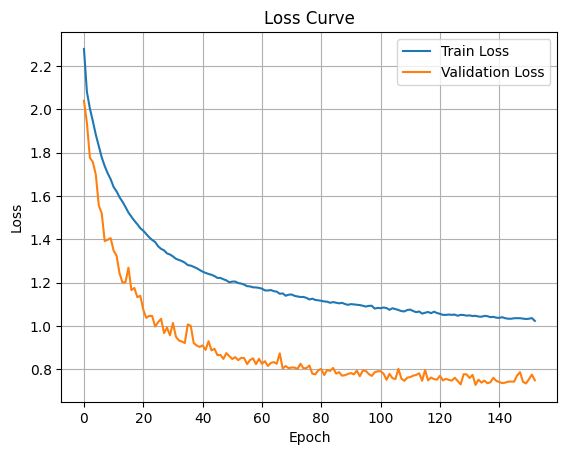

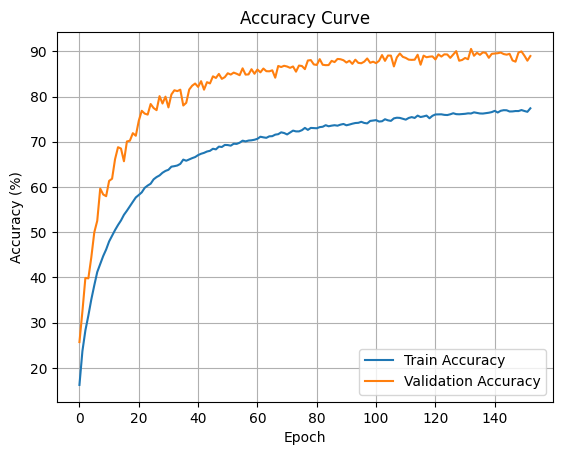

In [11]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# Log training 
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# Training and Validation Loops 
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# Main Loop 
patience = 20  # Number of epochs to wait for improvement
early_stop_counter = 0 # Counter for early stopping
epochs = 200
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        early_stop_counter=0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining Complete")

# Print Final Averages 
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# Plot results

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")
